<a href="https://colab.research.google.com/github/Tarakramasrisai/HematoVision-Advanced-Blood-Cell-Classification-Using-Transfer-Learning/blob/main/HematoVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import pandas as pd

import tensorflow as tf

from tensorflow import keras

import matplotlib.pyplot as pit

import seaborn as sns

import cv2


from tensorflow.keras.models import load_model

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print(os.path.isdir(data_dir))


True


In [ ]:
!ls "/content/drive/MyDrive/archive/dataset2-master/dataset2-master/images/train"


EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL


In [ ]:
import os
import pandas as pd

# Updated path to train folder
data_dir = "/content/drive/MyDrive/archive/dataset2-master/dataset2-master/images/train"

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

filepaths = []
labels = []

for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        print(f"Found {label}: {len(os.listdir(class_dir))} files")
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                full_path = os.path.join(class_dir, file)
                filepaths.append(full_path)
                labels.append(label)
            else:
                print(f"Skipping file (not image): {file}")
    else:
        print(f"Missing folder: {class_dir}")

bloodCell_df = pd.DataFrame({'Filepaths': filepaths, 'Labels': labels})
print("Total images collected:", len(filepaths))
print(bloodCell_df['Labels'].value_counts())
print(bloodCell_df.head())



Found EOSINOPHIL: 2497 files
Found LYMPHOCYTE: 2483 files
Found MONOCYTE: 2478 files
Found NEUTROPHIL: 2499 files
Total images collected: 9957
Labels
NEUTROPHIL    2499
EOSINOPHIL    2497
LYMPHOCYTE    2483
MONOCYTE      2478
Name: count, dtype: int64
                                           Filepaths      Labels
0  /content/drive/MyDrive/archive/dataset2-master...  EOSINOPHIL
1  /content/drive/MyDrive/archive/dataset2-master...  EOSINOPHIL
2  /content/drive/MyDrive/archive/dataset2-master...  EOSINOPHIL
3  /content/drive/MyDrive/archive/dataset2-master...  EOSINOPHIL
4  /content/drive/MyDrive/archive/dataset2-master...  EOSINOPHIL


In [ ]:
import os

data_dir = "/content/drive/MyDrive/archive/dataset2-master/dataset2-master/images/train"
class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

for label in class_labels:
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        print(f"Found folder: {label} with {len(os.listdir(class_dir))} files")
    else:
        print(f"Missing folder: {class_dir}")


Found folder: EOSINOPHIL with 2497 files
Found folder: LYMPHOCYTE with 2483 files
Found folder: MONOCYTE with 2478 files
Found folder: NEUTROPHIL with 2499 files


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup ImageDataGenerator with rescaling to [-1, 1]
datagen = ImageDataGenerator(
    rescale=1./127.5,  # because (x / 127.5) - 1 is the same as x rescaled this way
    preprocessing_function=lambda x: (x / 127.5) - 1  # normalize to [-1, 1]
)

train = datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/dataset2-master/dataset2-master/images/train',
    target_size=(150, 150),  # or your desired input size
    batch_size=32,
    class_mode='categorical'  # because you have multiple classes
)


Found 9957 images belonging to 4 classes.


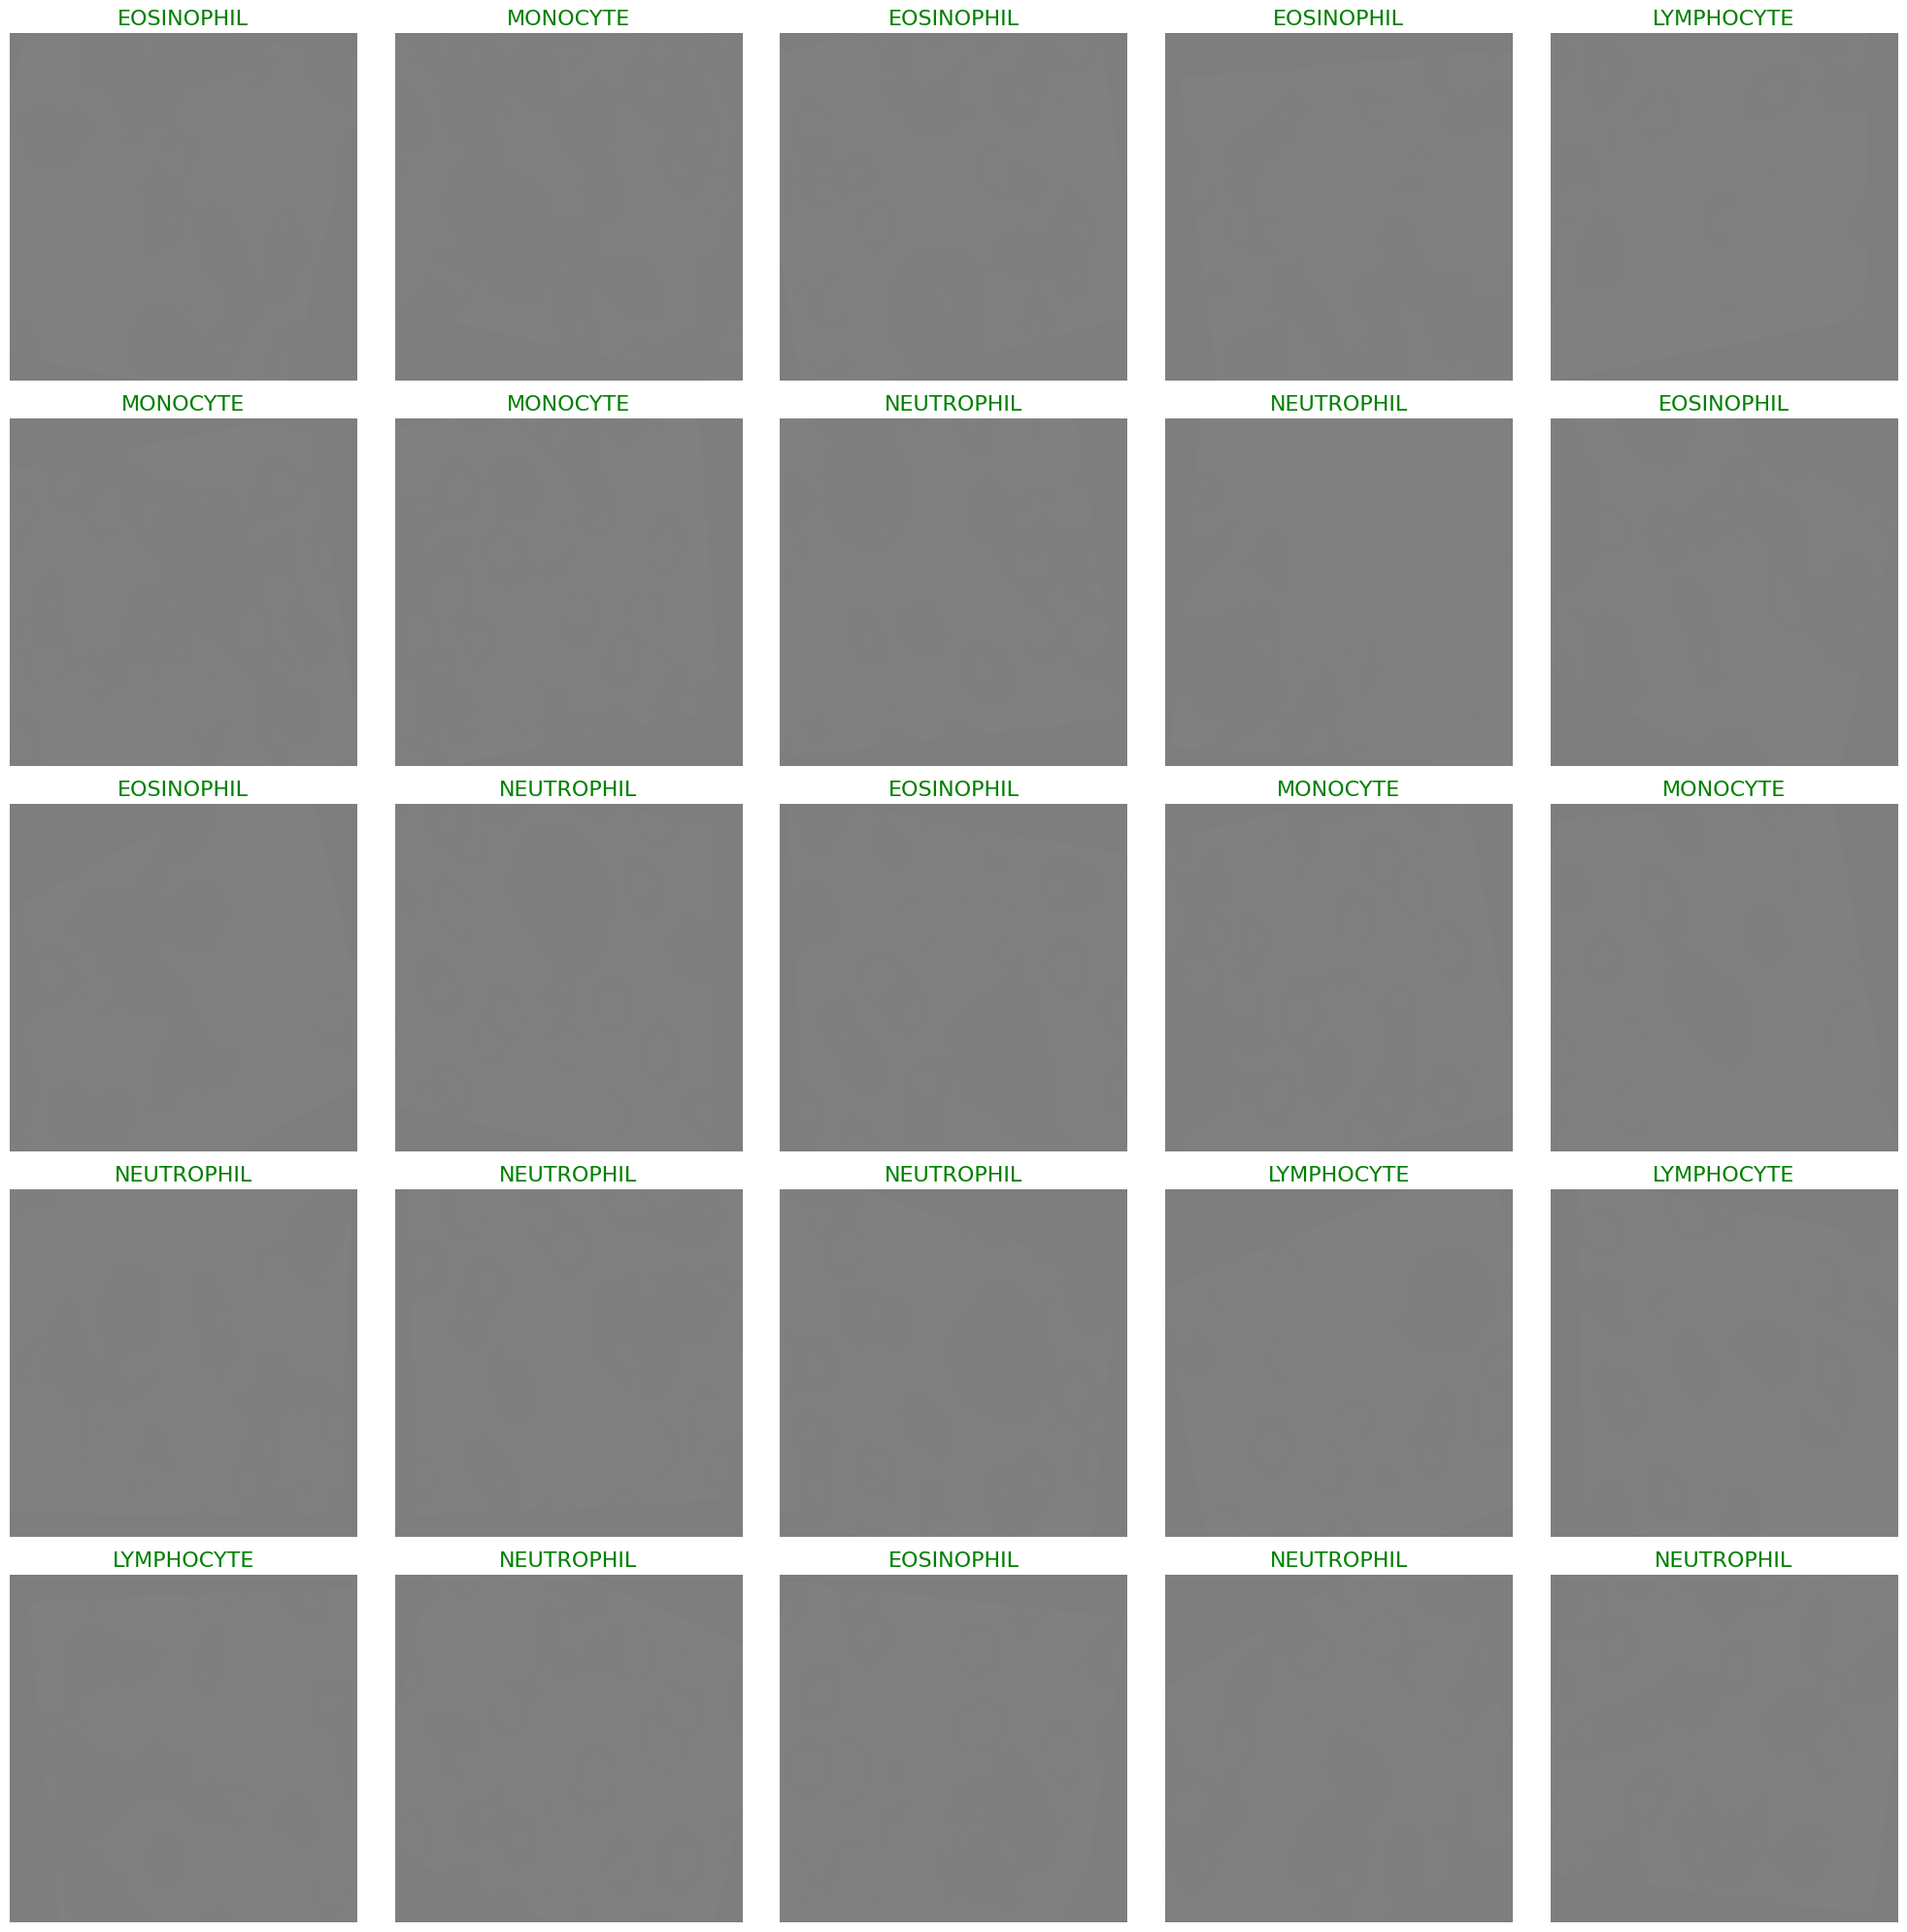

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_knee_images(image_gen):
    # Get class labels mapping from the generator
    test_dict = image_gen.class_indices
    classes = list(test_dict.keys())

    # Get a batch of images and labels
    images, labels = next(image_gen)

    plt.figure(figsize=(20, 20))

    length = len(labels)
    r = min(length, 25)  # Display up to 25 images

    for i in range(r):
        plt.subplot(5, 5, i + 1)

        # Rescale image to 0-1 if it was normalized to [-1, 1]
        image = (images[i] + 1) / 2

        plt.imshow(image)

        # If labels are one-hot encoded, find index
        index = np.argmax(labels[i])
        class_name = classes[index]

        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example call (assuming 'train' is your ImageDataGenerator iterator)
show_knee_images(train)

In [ ]:
from sklearn.model_selection import train_test_split

# First split: train and test
train_images, test_images = train_test_split(bloodCell_df, test_size=0.3, random_state=42)

# Second split: train into train_set and val_set
train_set, val_set = train_test_split(train_images, test_size=0.22, random_state=42)  # 0.22 of 70% ≈ 15.4%

# Print the shapes
print("Train Set:", train_set.shape)
print("Validation Set:", val_set.shape)
print("Test Set:", test_images.shape)
print("Original Train (before val split):", train_images.shape)


Train Set: (5435, 2)
Validation Set: (1534, 2)
Test Set: (2988, 2)
Original Train (before val split): (6969, 2)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Create the image data generator with MobileNetV2 preprocessing
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_image_gen = image_gen.flow_from_dataframe(
    dataframe=train_set,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(128, 128),      # reduced size for faster training
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,               # bigger batch size for faster training
    shuffle=True                 # shuffle training data for better training
)

test_image_gen = image_gen.flow_from_dataframe(
    dataframe=test_images,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(128, 128),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

val_image_gen = image_gen.flow_from_dataframe(
    dataframe=val_set,
    x_col="Filepaths",
    y_col="Labels",
    target_size=(128, 128),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)



Found 5435 validated image filenames belonging to 4 classes.
Found 2988 validated image filenames belonging to 4 classes.
Found 1534 validated image filenames belonging to 4 classes.


In [47]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Input(shape=(128, 128, 3)),

    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')  # 4 classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.2861 - loss: 1.3875 - val_accuracy: 0.4531 - val_loss: 1.1583
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.4950 - loss: 1.0915 - val_accuracy: 0.5645 - val_loss: 0.9905
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.6133 - loss: 0.8883 - val_accuracy: 0.6558 - val_loss: 0.7784
Epoch 1/2
170/170 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6922 - loss: 0.6768 - val_accuracy: 0.7308 - val_loss: 0.5950
Epoch 2/2
170/170 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.7488 - loss: 0.5549 - val_accuracy: 0.7751 - val_loss: 0.4868


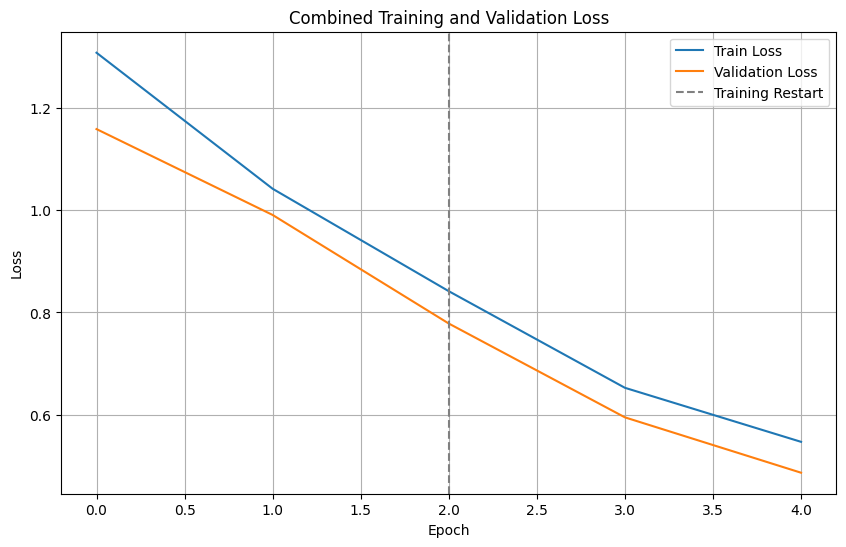

In [48]:
 # Train model for 3 epochs to test speed
history = model.fit(
    train_image_gen,
    validation_data=val_image_gen,
    epochs=3,
    verbose=1
)

# Optional: Continue training for 2 more epochs if you want
history1 = model.fit(
    train_image_gen,
    validation_data=val_image_gen,
    epochs=2,
    verbose=1
)

# Combine loss and val_loss from both training runs
import matplotlib.pyplot as plt

combined_loss = history.history['loss'] + history1.history['loss']
combined_val_loss = history.history['val_loss'] + history1.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(combined_loss, label='Train Loss')
plt.plot(combined_val_loss, label='Validation Loss')
plt.axvline(x=len(history.history['loss']) - 1, color='gray', linestyle='--', label='Training Restart')
plt.title('Combined Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
 import numpy as np
import matplotlib.pyplot as plt

# Get predictions on test set
pred = model.predict(test_image_gen)

# Convert predictions to class indices (e.g. [0, 1, 3, 2, ...])
pred_classes = np.argmax(pred, axis=1)

# Get label mapping from generator
labels = test_image_gen.class_indices

# Reverse the dictionary: index → class label
labels = dict((v, k) for k, v in labels.items())

# Convert predicted indices to class names
pred_class_names = [labels[k] for k in pred_classes]



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step


In [49]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# y_test: true labels (from test_image_gen)
y_test = test_image_gen.labels  # Assuming test_image_gen is the generator used for prediction

# Print classification report
print(classification_report(y_test, pred_classes, target_names=list(test_image_gen.class_indices.keys())))

# Print accuracy
print("Accuracy of the Model: {:.1f}%".format(accuracy_score(y_test, pred_classes) * 100))


              precision    recall  f1-score   support

  EOSINOPHIL       0.47      0.24      0.32       781
  LYMPHOCYTE       0.57      0.89      0.69       764
    MONOCYTE       0.59      0.67      0.63       729
  NEUTROPHIL       0.49      0.40      0.44       714

    accuracy                           0.55      2988
   macro avg       0.53      0.55      0.52      2988
weighted avg       0.53      0.55      0.52      2988

Accuracy of the Model: 54.9%


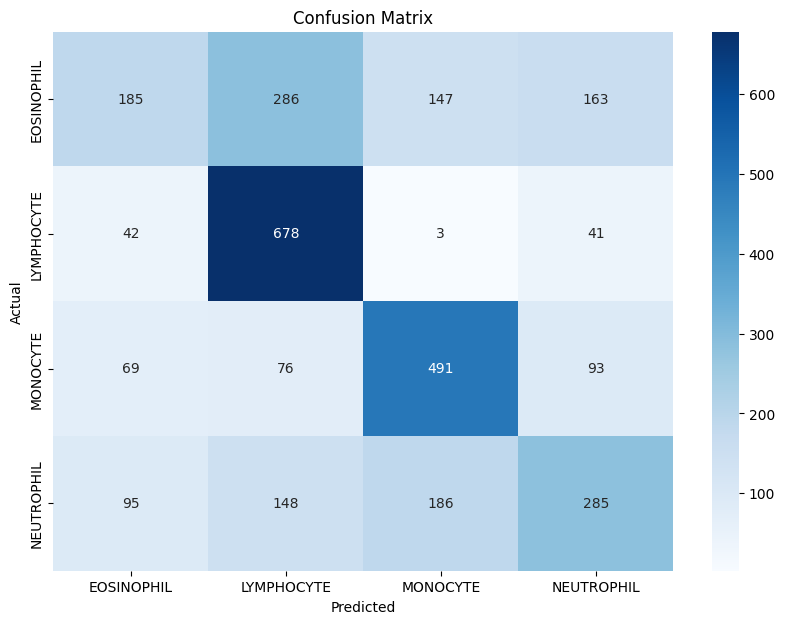

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_classes)

plt.figure(figsize=(10, 7))

sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")

plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()


In [53]:
model.save("blood_cell_model.keras")
